# Memento 6x6 "tout rotations" — Version minimale (ASCII-safe)

But: garder l'essentiel, sans sondes vectorielles ni micro-operateurs.

Contenu:
- Operateur physique local 6x6: M = [[R_ext, E_ext],[E_int, R_int]], chaque bloc 3x3 in SO(3).
- Etat-operateur (champ) 6x6: S = [[S_XX, S_XY],[S_YX, S_YY]], blocs 3x3 in SO(3).
- Sondes simples:
  - Droite (preparation): f_{i,j} = [e_i ; e_j] (6x1).
  - Gauche (detection scalaire): l_{p,q}^T = [e_p^T  e_q^T] (1x6).
- Temps: pas Delta_t et borne v <= c, tout en rotations.

Dualites clefs:
- Rotation <-> Translation: la translation lue vient de E_ext * Y_eff (aucune colonne affine).
- Transformation (M) <-> Champ (S): meme decomposition en blocs SO(3), dynamique multiplicative.
- Onde <-> Corpuscule: V = S * f, lecture scalaire alpha = l^T * M * S * f.


In [1]:
import pandas as pd
import sympy as sp
from IPython.display import display
sp.init_printing()
I3 = sp.eye(3)

# Rotations elementaires et compositions Euler
def Rx(a):
    c, s = sp.cos(a), sp.sin(a)
    return sp.Matrix([[1,0,0],[0,c,-s],[0,s,c]])

def Ry(a):
    c, s = sp.cos(a), sp.sin(a)
    return sp.Matrix([[c,0,s],[0,1,0],[-s,0,c]])

def Rz(a):
    c, s = sp.cos(a), sp.sin(a)
    return sp.Matrix([[c,-s,0],[s,c,0],[0,0,1]])

def euler_R(roll, pitch, yaw, order="ZYX"):
    order = order.upper()
    if order == "ZYX":
        return Rz(yaw) * Ry(pitch) * Rx(roll)
    if order == "XYZ":
        return Rx(roll) * Ry(pitch) * Rz(yaw)
    raise ValueError("ordre = 'ZYX' ou 'XYZ'")

def ok_SO3(R, tol=1e-10):
    RtR = (R.T * R).evalf()
    det = sp.N(R.det())
    return (RtR - sp.eye(3)).norm() < tol and abs(det - 1) < tol

# Utilitaires geometriques
def rotation_from_two_vectors(a, b):
    """
    R in SO(3) tel que R a = b, pour a,b unitaires (gere a = +/- b).
    """
    a = sp.Matrix(a); b = sp.Matrix(b)
    if (a - b).norm() < 1e-12:
        return I3
    if (a + b).norm() < 1e-12:
        # 180 deg autour d'un axe orthogonal a a
        if abs(a[0]) < 0.9:
            axis = sp.Matrix([1,0,0]).cross(a)
        else:
            axis = sp.Matrix([0,1,0]).cross(a)
        axis = axis / axis.norm()
        vx, vy, vz = axis
        Vx = sp.Matrix([[0,-vz,vy],[vz,0,-vx],[-vy,vx,0]])
        return I3 + 2 * Vx * Vx
    v = a.cross(b)
    s = v.norm()
    c = (a.T * b)[0]
    v = v / s
    vx, vy, vz = v
    Vx = sp.Matrix([[0,-vz,vy],[vz,0,-vx],[-vy,vx,0]])
    ang = sp.acos(c)
    return I3 + sp.sin(ang) * Vx + (1 - sp.cos(ang)) * (Vx * Vx)

def any_perp(u):
    """
    Retourne unitaire n perpendiculaire a u (u non nul).
    """
    u = sp.Matrix(u)
    trial = sp.Matrix([1,0,0]) if abs(u[0]) < 0.9 else sp.Matrix([0,1,0])
    n = u.cross(trial)
    n = n / n.norm()
    return n


## Construction de **M** et **S** (tous les blocs dans $SO(3)$)

In [2]:
def build_M(Rext, Rint, Eext, Eint):
    return sp.Matrix.vstack(sp.Matrix.hstack(Rext, Eext),
                            sp.Matrix.hstack(Eint, Rint))

def build_S(SXX, SXY, SYX, SYY):
    return sp.Matrix.vstack(sp.Matrix.hstack(SXX, SXY),
                            sp.Matrix.hstack(SYX, SYY))

# Blocs d'exemple (angles non triviaux, modifiables)
R_ext = euler_R(sp.pi/7,  sp.pi/6,  sp.pi/5,   "ZYX")
R_int = euler_R(sp.pi/10, sp.pi/9, -sp.pi/8,   "ZYX")
E_ext = euler_R(sp.pi/13,-sp.pi/12, sp.pi/11,  "ZYX")
E_int = euler_R(-sp.pi/16, sp.pi/15, sp.pi/14, "ZYX")

SXX = euler_R(sp.pi/9,   -sp.pi/10, sp.pi/18,  "ZYX")
SXY = euler_R(-sp.pi/12,  sp.pi/11, sp.pi/8,   "ZYX")
SYX = euler_R(sp.pi/15,   sp.pi/7, -sp.pi/13,  "ZYX")
SYY = euler_R(sp.pi/10,   sp.pi/9, -sp.pi/8,   "ZYX")

print("Verification SO(3) des 8 blocs:")
for name, R in [("R_ext",R_ext),("R_int",R_int),("E_ext",E_ext),("E_int",E_int),
                ("SXX",SXX),("SXY",SXY),("SYX",SYX),("SYY",SYY)]:
    print(f"  {name} in SO(3) ? -> {ok_SO3(R)}")

M = build_M(R_ext, R_int, E_ext, E_int)
S = build_S(SXX, SXY, SYX, SYY)

print("\nM =")
display(M)
print("\nS =")
display(S)


Verification SO(3) des 8 blocs:
  R_ext in SO(3) ? -> True
  R_int in SO(3) ? -> True
  E_ext in SO(3) ? -> True
  E_int in SO(3) ? -> True
  SXX in SO(3) ? -> True
  SXY in SO(3) ? -> True
  SYX in SO(3) ? -> True
  SYY in SO(3) ? -> True

M =


⎡               ⎛1   √5⎞                                                       ↪
⎢            √3⋅⎜─ + ──⎟                                 ________              ↪
⎢               ⎝4   4 ⎠                                ╱ 5   √5     ⎛π⎞   ⎛1  ↪
⎢            ───────────                           -   ╱  ─ - ── ⋅cos⎜─⎟ + ⎜─  ↪
⎢                 2                                  ╲╱   8   8      ⎝7⎠   ⎝8  ↪
⎢                                                                              ↪
⎢                 ________                              ________               ↪
⎢                ╱ 5   √5                              ╱ 5   √5     ⎛π⎞        ↪
⎢          √3⋅  ╱  ─ - ──                             ╱  ─ - ── ⋅sin⎜─⎟        ↪
⎢             ╲╱   8   8                            ╲╱   8   8      ⎝7⎠   ⎛1   ↪
⎢          ───────────────                          ─────────────────── + ⎜─ + ↪
⎢                 2                                          2            ⎝4   ↪
⎢                           


S =


⎡    ________                                                                  ↪
⎢   ╱ √5   5     ⎛π ⎞                            ⎛π ⎞    ⎛π⎞   ⎛1   √5⎞    ⎛π⎞ ↪
⎢  ╱  ── + ─ ⋅cos⎜──⎟                       - sin⎜──⎟⋅cos⎜─⎟ + ⎜─ - ──⎟⋅sin⎜─⎟ ↪
⎢╲╱   8    8     ⎝18⎠                            ⎝18⎠    ⎝9⎠   ⎝4   4 ⎠    ⎝9⎠ ↪
⎢                                                                              ↪
⎢    ________                                                                  ↪
⎢   ╱ √5   5     ⎛π ⎞                        ⎛1   √5⎞    ⎛π ⎞    ⎛π⎞      ⎛π ⎞ ↪
⎢  ╱  ── + ─ ⋅sin⎜──⎟                        ⎜─ - ──⎟⋅sin⎜──⎟⋅sin⎜─⎟ + cos⎜──⎟ ↪
⎢╲╱   8    8     ⎝18⎠                        ⎝4   4 ⎠    ⎝18⎠    ⎝9⎠      ⎝18⎠ ↪
⎢                                                                              ↪
⎢                                                          ________            ↪
⎢        1   √5                                           ╱ √5   5     ⎛π⎞     ↪
⎢      - ─ + ──             

## Sondes simples : droite (preparation) et gauche (detection scalaire)

- Sonde droite: f_{i,j} = [e_i ; e_j] (6x1).
- Sonde gauche scalaire: l_{p,q}^T = [e_p^T  e_q^T] (1x6).
- Lecture: alpha = l^T * M * S * f (decomposee en 8 termes).

In [3]:
# Base canonique
e1, e2, e3 = sp.Matrix([1,0,0]), sp.Matrix([0,1,0]), sp.Matrix([0,0,1])
basis = [e1, e2, e3]

def right_probe_pair(i, j):
    """ f_{i,j} = [e_i ; e_j] """
    return sp.Matrix.vstack(basis[i-1], basis[j-1])

def left_scalar_probe(p, q):
    """ l_{p,q}^T = [e_p^T  e_q^T] """
    return sp.Matrix.hstack(basis[p-1].T, basis[q-1].T)

# Exemple de sondes (modifie librement)
i, j = 1, 3   # f = (e1, e3)
p, q = 2, 2   # l lit X'[2] + Y'[2]

f = right_probe_pair(i, j)
lT = left_scalar_probe(p, q)

print("f_{i,j} =")
display(f)
print("l_{p,q}^T =")
display(lT)


f_{i,j} =


⎡1⎤
⎢ ⎥
⎢0⎥
⎢ ⎥
⎢0⎥
⎢ ⎥
⎢0⎥
⎢ ⎥
⎢0⎥
⎢ ⎥
⎣1⎦

l_{p,q}^T =


[0  1  0  0  1  0]

## Démo — Sonde scalaire : $\alpha=\ell^\top M S f$ et **8 contributions**

V0 = S * f (exact) :


⎡      ________                   ________                         ________    ↪
⎢     ╱ 1   √2  ⎛  √2   √6⎞      ╱ √2   1  ⎛√2   √6⎞    ⎛π ⎞      ╱ √5   5     ↪
⎢-   ╱  ─ - ── ⋅⎜- ── + ──⎟ +   ╱  ── + ─ ⋅⎜── + ──⎟⋅sin⎜──⎟ +   ╱  ── + ─ ⋅co ↪
⎢  ╲╱   2   4   ⎝  4    4 ⎠   ╲╱   4    2  ⎝4    4 ⎠    ⎝11⎠   ╲╱   8    8     ↪
⎢                                                                              ↪
⎢     ________                         ________                           ____ ↪
⎢    ╱ 1   √2  ⎛√2   √6⎞    ⎛π ⎞      ╱ √5   5     ⎛π ⎞   ⎛  √2   √6⎞    ╱ √2  ↪
⎢   ╱  ─ - ── ⋅⎜── + ──⎟⋅sin⎜──⎟ +   ╱  ── + ─ ⋅sin⎜──⎟ + ⎜- ── + ──⎟⋅  ╱  ──  ↪
⎢ ╲╱   2   4   ⎝4    4 ⎠    ⎝11⎠   ╲╱   8    8     ⎝18⎠   ⎝  4    4 ⎠ ╲╱   4   ↪
⎢                                                                              ↪
⎢                             1   √5   ⎛√2   √6⎞    ⎛π ⎞                       ↪
⎢                           - ─ + ── + ⎜── + ──⎟⋅cos⎜──⎟                       ↪
⎢                           

V0 (numérique, 6 décimales) :


⎡1.08898 ⎤
⎢        ⎥
⎢0.508408⎥
⎢        ⎥
⎢1.23582 ⎥
⎢        ⎥
⎢1.05705 ⎥
⎢        ⎥
⎢-0.62559⎥
⎢        ⎥
⎣0.459817⎦


V1 = M * V0 (exact) :


⎡                                                                              ↪
⎢                                                                              ↪
⎢                                                  ⎛      ________             ↪
⎢                                                  ⎜     ╱ 5   √5     ⎛π⎞   ⎛1 ↪
⎢                                                  ⎜-   ╱  ─ - ── ⋅cos⎜─⎟ + ⎜─ ↪
⎢                                                  ⎝  ╲╱   8   8      ⎝7⎠   ⎝8 ↪
⎢                                                                              ↪
⎢                                                                              ↪
⎢                                                                              ↪
⎢                                                                              ↪
⎢                                                ⎛⎛  √6   √2⎞    ⎛π ⎞    ⎛π ⎞  ↪
⎢                                                ⎜⎜- ── + ──⎟⋅sin⎜──⎟⋅sin⎜──⎟  ↪
⎢                           

V1 (numérique, 6 décimales) :


⎡ 2.45664 ⎤
⎢         ⎥
⎢0.460803 ⎥
⎢         ⎥
⎢ 1.17102 ⎥
⎢         ⎥
⎢ 1.81218 ⎥
⎢         ⎥
⎢-0.083313⎥
⎢         ⎥
⎣ 0.7299  ⎦


alpha (p,q <- i,j) (exact) :


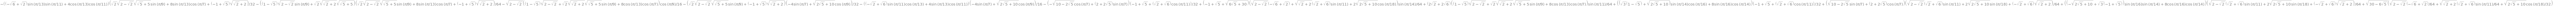

alpha (numérique) :



Contributions (8 termes) :


terme                                              exact  \
0  (R_ext SXX)_{p,i}  (1 - sqrt(5))*(-sqrt(10 - 2*sqrt(5))*cos(pi/7)...   
1  (R_ext SXY)_{p,j}  (-2*sqrt(6) - 2*sqrt(2))*(-sqrt(10 - 2*sqrt(5)...   
2  (E_ext SYX)_{p,i}  -((-sqrt(6) + sqrt(2))*sin(pi/13)*sin(pi/11) +...   
3  (E_ext SYY)_{p,j}  -((-sqrt(6) + sqrt(2))*sin(pi/13)*sin(pi/11) +...   
4  (E_int SXX)_{q,i}  (-1 + sqrt(5))*((sqrt(3)*(1 - sqrt(5)) + sqrt(...   
5  (E_int SXY)_{q,j}  (sqrt(2 - sqrt(2))*(-sqrt(6) + sqrt(2)) + sqrt...   
6  (R_int SYX)_{q,i}  -sqrt(2 - sqrt(2))*cos(pi/13)*cos(pi/9)*cos(pi...   
7  (R_int SYY)_{q,j}  -sqrt(2*sqrt(5) + 10)*(sqrt(2)*sqrt(2 - sqrt(2...   

  numérique ~1e-6  
0        0.591557  
1        0.291615  
2        0.171298  
3       -0.593668  
4        0.433081  
5        0.576619  
6       -0.317430  
7       -0.775584

In [4]:
# Préparation puis action
V0 = S * f                 # [X_eff ; Y_eff]
V1 = M * V0                # [X' ; Y']
alpha = (lT * V1)[0]

# Affichage lisible : exact puis numérique
print("V0 = S * f (exact) :")
display(V0)
print("V0 (numérique, 6 décimales) :")
display(V0.evalf(6))

print("\nV1 = M * V0 (exact) :")
display(V1)
print("V1 (numérique, 6 décimales) :")
display(V1.evalf(6))

print("\nalpha (p,q <- i,j) (exact) :")
display(sp.simplify(alpha))
print("alpha (numérique) :")
display(sp.N(alpha, 6))

# Décomposition des 8 contributions (exact + numérique) SANS sympy.Matrix
termXX_p = sp.simplify((R_ext * SXX)[p-1, i-1])
termXY_p = sp.simplify((R_ext * SXY)[p-1, j-1])
termYX_p = sp.simplify((E_ext * SYX)[p-1, i-1])
termYY_p = sp.simplify((E_ext * SYY)[p-1, j-1])

termXX_q = sp.simplify((E_int * SXX)[q-1, i-1])
termXY_q = sp.simplify((E_int * SXY)[q-1, j-1])
termYX_q = sp.simplify((R_int * SYX)[q-1, i-1])
termYY_q = sp.simplify((R_int * SYY)[q-1, j-1])

rows = [
    ("(R_ext SXX)_{p,i}", termXX_p, sp.N(termXX_p, 6)),
    ("(R_ext SXY)_{p,j}", termXY_p, sp.N(termXY_p, 6)),
    ("(E_ext SYX)_{p,i}", termYX_p, sp.N(termYX_p, 6)),
    ("(E_ext SYY)_{p,j}", termYY_p, sp.N(termYY_p, 6)),
    ("(E_int SXX)_{q,i}", termXX_q, sp.N(termXX_q, 6)),
    ("(E_int SXY)_{q,j}", termXY_q, sp.N(termXY_q, 6)),
    ("(R_int SYX)_{q,i}", termYX_q, sp.N(termYX_q, 6)),
    ("(R_int SYY)_{q,j}", termYY_q, sp.N(termYY_q, 6)),
]

print("\nContributions (8 termes) :")
df = pd.DataFrame(rows, columns=["terme", "exact", "numérique ~1e-6"])
display(df)


## Temps, borne c et composition "tout rotations" (multi-pas)

- Vielbein e (monde non-euclidien) pour convertir en "monde".
- Design d'un pas: (SYX, SYY) sont choisis pour produire t_world* = Delta_t * v * d_hat.
- Calibration: Delta_t = 2/c => ||t_world||/Delta_t <= c par pas, sans gains d'amplitude.

Delta_t = 2.0 (avec c = 1 )

-- Pas 1 --
t* (monde) :


⎡2.0⎤
⎢   ⎥
⎢ 0 ⎥
⎢   ⎥
⎣ 0 ⎦

t_world obtenu :


⎡4.0⎤
⎢   ⎥
⎢ 0 ⎥
⎢   ⎥
⎣ 0 ⎦

vitesse par pas = ||t||/Delta_t :


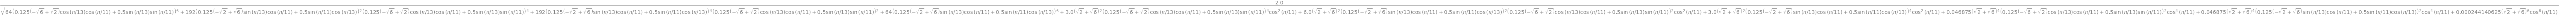


-- Pas 2 --
t* (monde) :


⎡ 0 ⎤
⎢   ⎥
⎢1.0⎥
⎢   ⎥
⎣ 0 ⎦

t_world obtenu :


⎡ 0 ⎤
⎢   ⎥
⎢1.0⎥
⎢   ⎥
⎣ 0 ⎦

vitesse par pas = ||t||/Delta_t :



-- Pas 3 --
t* (monde) :


⎡ 0 ⎤
⎢   ⎥
⎢ 0 ⎥
⎢   ⎥
⎣2.0⎦

t_world obtenu :


⎡ 0 ⎤
⎢   ⎥
⎢ 0 ⎥
⎢   ⎥
⎣1.0⎦

vitesse par pas = ||t||/Delta_t :



Position monde accumulee (somme des translations) :


⎡4.0⎤
⎢   ⎥
⎢1.0⎥
⎢   ⎥
⎣1.0⎦

In [5]:
# Vielbein (monde non-euclidien) — peut etre I3
e = sp.diag(2, 1, sp.Rational(1,2))

def design_step_SO3(e, E_ext, i, j, t_world_star):
    """
    Concoit (SYX, SYY) in SO(3) pour realiser une translation monde cible t_world_star
    sur un pas Delta_t, sans gains (tout rotations).
    """
    e_inv = e.inv()
    r = t_world_star.norm()
    if r == 0:
        return I3, I3, sp.zeros(3,1)
    d_hat = t_world_star / r
    u_local = E_ext.T * (e_inv * d_hat)
    u_local = u_local / u_local.norm()
    if r > 2:
        raise ValueError("||t*|| doit etre <= 2 ; fixer Delta_t = 2/c pour v <= c.")
    theta = sp.acos(r/2)   # r = 2 cos theta
    n = any_perp(u_local)
    a =  sp.cos(theta)*u_local + sp.sin(theta)*n
    b =  sp.cos(theta)*u_local - sp.sin(theta)*n

    ei, ej = basis[i-1], basis[j-1]
    SYX = rotation_from_two_vectors(ei, a)
    SYY = rotation_from_two_vectors(ej, b)

    Y_eff = a + b
    t_world = e * (E_ext * Y_eff)
    return SYX, SYY, t_world

def one_step(e, R_ext, R_int, E_ext, E_int, SXX, SXY, SYX, SYY, i, j):
    M_loc  = build_M(R_ext, R_int, E_ext, E_int)
    S_loc  = build_S(SXX, SXY, SYX, SYY)
    f_loc  = sp.Matrix.vstack(basis[i-1], basis[j-1])
    V0_loc = S_loc * f_loc
    V1_loc = M_loc * V0_loc
    X1_world = e * V1_loc[:3,:]
    return X1_world, V0_loc, V1_loc, S_loc, M_loc

# Blocs M pour la demo multi-pas (tu peux re-utiliser ceux definis plus haut)
R_ext = euler_R(sp.pi/7,  sp.pi/6,  sp.pi/5,   "ZYX")
R_int = euler_R(sp.pi/10, sp.pi/9, -sp.pi/8,   "ZYX")
E_ext = euler_R(sp.pi/13,-sp.pi/12, sp.pi/11,  "ZYX")
E_int = euler_R(-sp.pi/16, sp.pi/15, sp.pi/14, "ZYX")

# Blocs S constants sauf SYX, SYY re-designes a chaque pas
SXX = euler_R(sp.pi/9,  -sp.pi/10, sp.pi/18,  "ZYX")
SXY = euler_R(-sp.pi/12, sp.pi/11,  sp.pi/8,  "ZYX")

# Choix de sonde (e_i, e_j)
i, j = 1, 3

# Calibration relativiste: c = 1 -> Delta_t = 2
c_val = 1
Delta_t = 2 / c_val

# Exemples de directions et vitesses par pas
d_list = [sp.Matrix([1,0,0]), sp.Matrix([0,1,0]), sp.Matrix([0,0,1])]
v_list = [1, 0.5, 1]  # v <= c

print("Delta_t =", Delta_t, "(avec c =", c_val, ")")
X_world_acc = sp.zeros(3,1)
for k, (d_hat, v) in enumerate(zip(d_list, v_list), start=1):
    t_star = Delta_t * v * d_hat
    SYX_k, SYY_k, t_world_k = design_step_SO3(e, E_ext, i, j, t_star)
    X1_world, V0_k, V1_k, S_blk, M_blk = one_step(
        e, R_ext, R_int, E_ext, E_int, SXX, SXY, SYX_k, SYY_k, i, j
    )
    X_world_acc += t_world_k
    print("\n-- Pas", k, "--")
    print("t* (monde) :"); display(sp.simplify(t_star))
    print("t_world obtenu :"); display(sp.simplify(t_world_k))
    print("vitesse par pas = ||t||/Delta_t :"); display(sp.simplify(t_world_k.norm()/Delta_t))

print("\nPosition monde accumulee (somme des translations) :")
display(sp.simplify(X_world_acc))



## Cheat-Sheet (essentiel)
- Preparation: V0 = S * f_{i,j}, avec f_{i,j} = [e_i ; e_j].
- Action: V1 = M * V0 = [X' ; Y'] avec X' = R_ext X_eff + E_ext Y_eff, Y' = E_int X_eff + R_int Y_eff.
- Sonde scalaire: alpha = l_{p,q}^T * V1 = e_p^T X' + e_q^T Y'.
- Lecture monde: X'_world = e * X', t_world = e * (E_ext * Y_eff).
- Borne vitesse: choisir Delta_t = 2/c => a chaque pas, ||t_world||/Delta_t <= c (purement rotations).